## Redes Bayesianas

### Introdução
Redes Bayesianas são modelos que usam probabilidade pra representar relações entre variáveis. Elas ajudam a prever eventos com base em dados conhecidos, mesmo quando há incertezas.

Neste projeto, a ideia é aplicar redes bayesianas pra prever enchentes em São Luís. As variáveis usadas incluem precipitação nas últimas 24h, intensidade e duração da chuva, nível da maré, bairro, topografia e qualidade da drenagem Com isso, é possível calcular a probabilidade de alagamento em determinadas regiões, ajudando na prevenção e tomada de decisões.

## Setup - Instalações e Importações

Esta célula instala as bibliotecas necessárias e carrega os dados do GitHub.


---



In [ ]:
!pip install pgmpy
#Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# pgmpy - Redes Bayesianas
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import PC


#Datasets no GitHub
url_principal = 'https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_eventos_climaticos_limpo.csv'
url_pequeno = 'https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_enchentes_limpo.csv'


##Tabela para pré-visualização
Essa tabela mostra alguns dados retirados dos Datasets


---

In [2]:
# Carrega dataset de eventos climáticos em São Luís
#df = pd.read_csv('https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_eventos_climaticos_limpo.csv')

# Carrega dataset de enchentes em São Luís
df = pd.read_csv('https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_enchentes_limpo.csv')

# Mostra 10 primeiras linhas do dataset
df.head(10)


,precipitacao_mm,intensidade_chuva,duracao_chuva,mare,bairro,topografia,drenagem,enchente
0,85.2,intensa,6h+,alta,Centro,baixa,inadequada,True
1,45.1,moderada,2-6h,média,Vinhais,média,adequada,False
2,92.7,intensa,6h+,alta,João Paulo,baixa,inadequada,True
3,23.5,fraca,<2h,baixa,Renascença,alta,adequada,False
4,67.8,intensa,2-6h,média,Cohama,baixa,regular,True
5,15.2,fraca,<2h,baixa,Alemanha,média,regular,False
6,76.3,intensa,6h+,alta,São Francisco,baixa,inadequada,True
7,38.9,moderada,2-6h,baixa,Calhau,baixa,regular,False
8,55.1,intensa,2-6h,alta,Centro,baixa,inadequada,True
9,29.7,fraca,2-6h,média,Vinhais,média,adequada,False


##Estimar estrutura
Esta célula mostra as principais variáveis que influenciam na probabilidade de enchente

---



##Normalização dos dados categóricos(validação dos valores únicos)
Garantimos que não há inconsistências nos valores das variáveis categóricas, como erros de digitação ou diferenças de maiúsculas/minúsculas.

- Reduz erros na estimativa de CPDs(por conta de duplicidade de categorias)
- Garante consistência nas inferências

In [ ]:
# Normalizar valores categóricos para minúsculas e remover espaços extras
df['bairro'] = df['bairro'].str.lower().str.strip()
df['topografia'] = df['topografia'].str.lower().str.strip()
df['drenagem'] = df['drenagem'].str.lower().str.strip()
df['enchente'] = df['enchente'].astype(bool)  # Garante que esteja como booleano

# Verificar os valores únicos
print("Valores únicos - Topografia:", df['topografia'].unique())
print("Valores únicos - Drenagem:", df['drenagem'].unique())
print("Valores únicos - Bairro:", df['bairro'].unique()[:5], "...")  # Mostra só os 5 primeiros

In [3]:
est = PC( df )
modelo_estimado = est.estimate(variant = 'stable' , max_cond_vars=4)
print("Estrutura estimada:")
print(modelo_estimado.edges())

print("\nNós da rede:")
print(modelo_estimado.nodes())


  0%|          | 0/5 [00:00<?, ?it/s]

Estrutura estimada:
[('topografia', 'drenagem'), ('topografia', 'bairro'), ('drenagem', 'enchente'), ('drenagem', 'topografia'), ('drenagem', 'bairro'), ('bairro', 'topografia'), ('bairro', 'drenagem'), ('enchente', 'drenagem')]

Nós da rede:
['topografia', 'drenagem', 'bairro', 'enchente', 'intensidade_chuva', 'mare', 'duracao_chuva', 'precipitacao_mm']


##Grafo da rede
Este grafo mostra as principais variáveis que influenciam na probabilidade de enchente


---



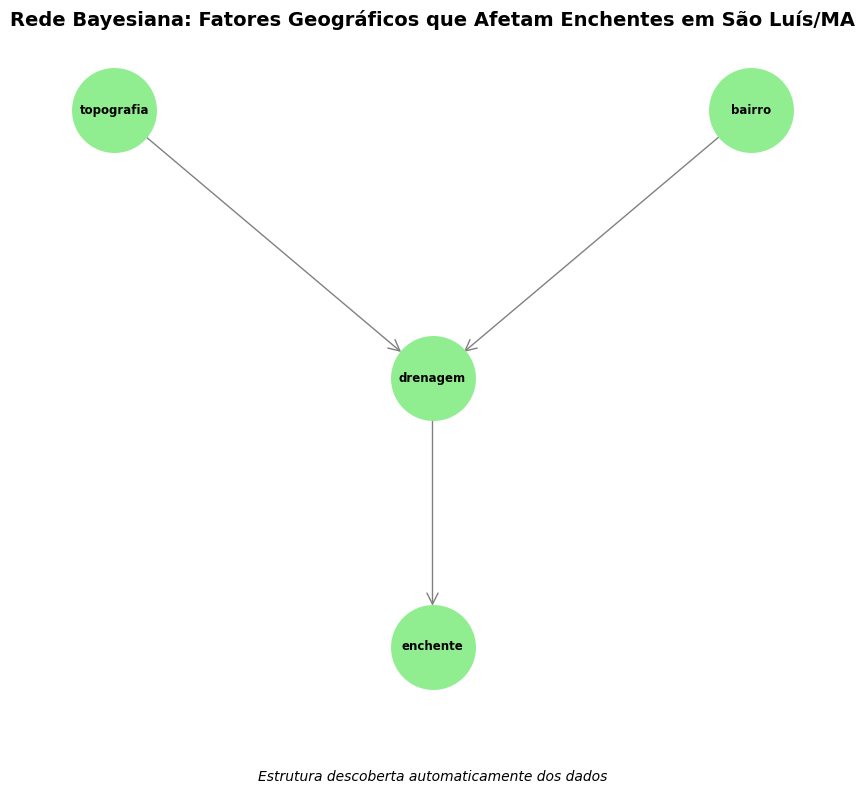


RELAÇÕES CAUSAIS DESCOBERTAS:
• Topografia → Drenagem
• Bairro → Drenagem
• Drenagem → Enchente

A análise dos dados mostra que fatores geográficos são mais determinantes.


In [4]:
# Definir a estrutura da rede baseada na descoberta automática
# Drenagem → Enchente
# Bairro → Drenagem
# Topografia → Drenagem
model = DiscreteBayesianNetwork([
    ('drenagem', 'enchente'),
    ('bairro', 'drenagem'),
    ('topografia', 'drenagem')
])

# Criar o grafo para visualização
plt.figure(figsize=(8, 8))

# Converter para NetworkX para plotar
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Definir posições dos nós manualmente para melhor visualização
pos = {
    'topografia': (-1, 1),
    'bairro': (1, 1),
    'drenagem': (0, 0),
    'enchente': (0, -1)
}

# Desenhar o grafo
plt.subplot(111)
nx.draw(G, pos,
        with_labels=True,
        node_color='lightgreen',
        node_size=3500,
        font_size=8.5,
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        edge_color='gray',
        linewidths=2)

plt.title('Rede Bayesiana: Fatores Geográficos que Afetam Enchentes em São Luís/MA',
          fontsize=14, fontweight='bold', pad=20)

# Adicionar legenda
plt.text(0, -1.5, 'Estrutura descoberta automaticamente dos dados',
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Mostrar informações sobre a rede
print("\nRELAÇÕES CAUSAIS DESCOBERTAS:")
print("• Topografia → Drenagem")
print("• Bairro → Drenagem")
print("• Drenagem → Enchente")
print("\nA análise dos dados mostra que fatores geográficos são mais determinantes.")

##Estimação das Tabelas de Probabilidades Condicional(CPDs)
Com a estrutura da Rede Bayesiana definida (focando nos fatores geográficos), o passo crucial é estimar as Tabelas de Probabilidade Condicional (CPDs) para cada variável da rede. As CPDs quantificam as relações probabilísticas entre as variáveis.

Utilizaremos o `MaximumLikelihoodEstimator` da `pgmpy` para aprender essas probabilidades a partir dos dados do DataFrame `df` (proveniente do `sao_luis_enchentes_limpo.csv`).

In [5]:

# 1. Selecionar as colunas relevantes do DataFrame 'df' para o ajuste do 'model'
# As variáveis no 'model' que você definiu são: 'topografia', 'bairro', 'drenagem', 'enchente'
data_for_model_fit = df[['topografia', 'bairro', 'drenagem', 'enchente']]

# 2. Estimar as CPDs usando Maximum Likelihood Estimator.
# O método fit() da classe DiscreteBayesianNetwork irá preencher as CPDs para o objeto 'model'.
print("Estimando CPDs para o modelo...")
model.fit(data_for_model_fit, estimator=MaximumLikelihoodEstimator)
print("Estimação de CPDs concluída.")

# 3. Exibir as CPDs estimadas
print("\nCPDs Estimadas para o Modelo:")
for cpd in model.get_cpds():
    print(f"\nCPD para a variável: {cpd.variable}")
    print("------------------------------------")
    # A pgmpy pode ter um __str__ um pouco verboso para CPDs grandes.
    # Você pode querer inspecionar os valores da cpd de 'drenagem' com mais cuidado
    # se a saída for muito longa. Ex: print(cpd.values) ou cpd.to_df()
    print(cpd)
    if cpd.variable == 'drenagem':
        print(f"(Nota: A CPD para '{cpd.variable}' é extensa devido ao número de combinações dos pais 'bairro' e 'topografia')")
        print(f"  Número de estados de 'bairro': {len(df['bairro'].unique())}")
        print(f"  Número de estados de 'topografia': {len(df['topografia'].unique())}")
        print(f"  Número de estados de 'drenagem': {len(df['drenagem'].unique())}")

# 4. Verificar se o modelo (com as CPDs) está completamente definido e é válido
try:
    model.check_model()
    print("\n[SUCESSO] O modelo Bayesiano (estrutura + CPDs) foi verificado e é válido!")
    print("O modelo agora está pronto para inferência.")
except Exception as e:
    print(f"\n[ERRO] Problema na verificação do modelo: {e}")

Estimando CPDs para o modelo...
Estimação de CPDs concluída.

CPDs Estimadas para o Modelo:

CPD para a variável: drenagem
------------------------------------
+----------------------+-----+-------------------+
| bairro               | ... | bairro(Vinhais)   |
+----------------------+-----+-------------------+
| topografia           | ... | topografia(média) |
+----------------------+-----+-------------------+
| drenagem(adequada)   | ... | 1.0               |
+----------------------+-----+-------------------+
| drenagem(inadequada) | ... | 0.0               |
+----------------------+-----+-------------------+
| drenagem(regular)    | ... | 0.0               |
+----------------------+-----+-------------------+
(Nota: A CPD para 'drenagem' é extensa devido ao número de combinações dos pais 'bairro' e 'topografia')
  Número de estados de 'bairro': 8
  Número de estados de 'topografia': 3
  Número de estados de 'drenagem': 3

CPD para a variável: enchente
--------------------------------

##Validação da Rede Bayesiana usando o método de Hold-Out (Técnica de avaliação de desempenho preditivo)
Objetivo Geral:
Avaliar se o modelo realmente aprende a prever enchentes com base nos dados. Para isso, ele:
- Separa parte dos dados para treino (70%) e parte para teste (30%);
- Treina a rede com os dados de treino;
- Usa os dados de teste para ver se a rede acerta as previsões;
- Calcula métricas para medir esse desempenho.

In [ ]:
# Ajustar CPDs
model.fit(df, estimator=MaximumLikelihoodEstimator)
model.check_model()

# → MELHORIA 3: Validação com Hold-out <- #

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from pgmpy.inference import VariableElimination

# 1. Dividir os dados em treino e teste
data = df[['bairro', 'topografia', 'drenagem', 'enchente']]
train, test = train_test_split(data, test_size=0.3, random_state=42)

# 2. Reajustar CPDs no modelo com os dados de treino
model.fit(train, estimator=MaximumLikelihoodEstimator)

# 3. Fazer inferência
inference = VariableElimination(model)

# 4. Estimar probabilidades de enchente no conjunto de teste
y_true = test['enchente'].astype(int)
probs = []
for _, row in test.iterrows():
    ev = row.drop('enchente').to_dict()
    q = inference.query(['enchente'], evidence=ev)
    probs.append(q.values[1])  # probabilidade de enchente=True

# 5. Calcular métricas
auc = roc_auc_score(y_true, probs)
y_pred = [1 if p > 0.5 else 0 for p in probs]
cm = confusion_matrix(y_true, y_pred)

print(f"\n Desempenho do Modelo (Hold-out):")
print(f"ROC AUC: {auc:.3f}")
print("Matriz de Confusão:\n", cm)


 DIAGNOSTICANDO 5 bairros com enchente


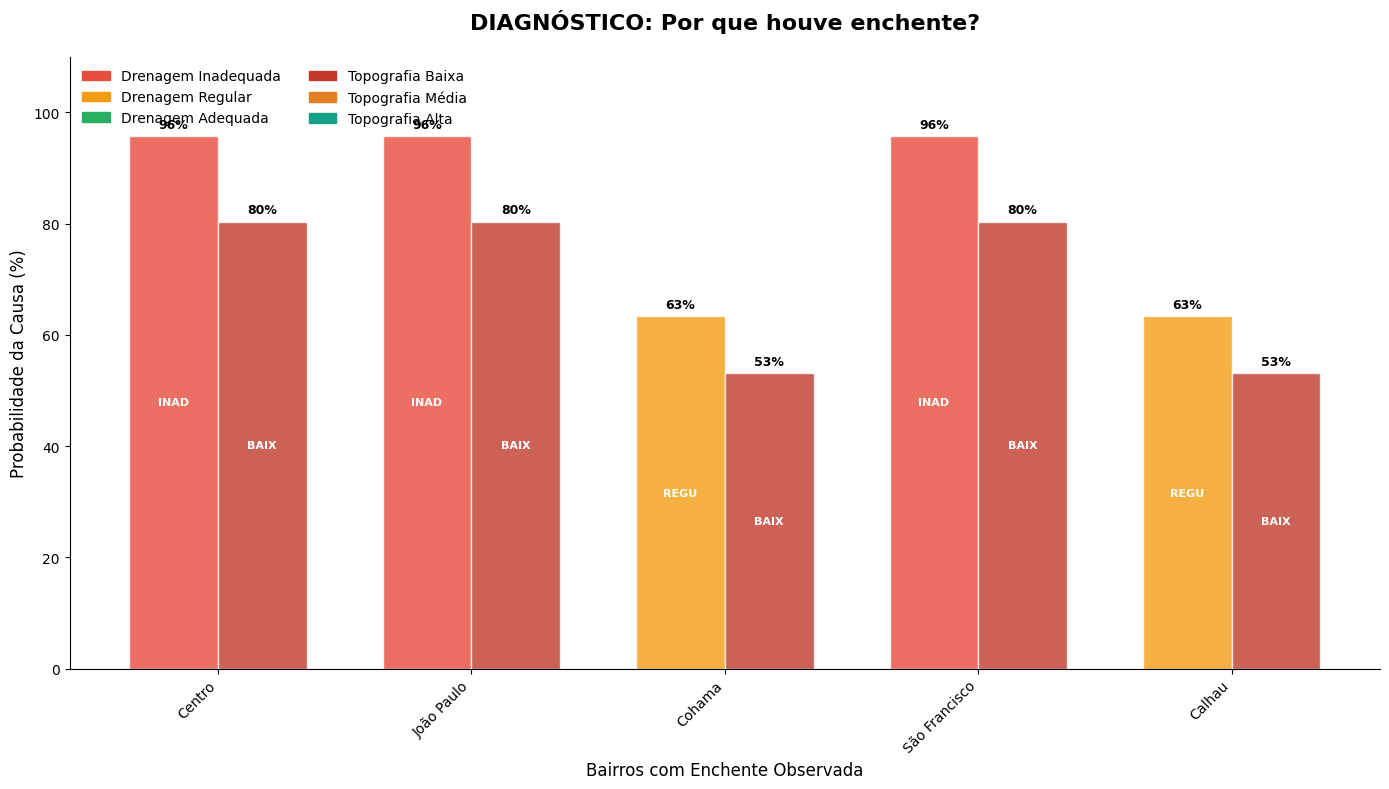


 DIAGNÓSTICO POR BAIRRO:
Centro: inadequada + baixa |  CRÍTICO
João Paulo: inadequada + baixa |  CRÍTICO
Cohama: regular + baixa |  ALTO
São Francisco: inadequada + baixa |  CRÍTICO
Calhau: regular + baixa |  ALTO

 PRINCIPAIS CAUSAS:
• Drenagem: inadequada
• Topografia: baixa


In [6]:
# ========================================
# DIAGNÓSTICO: UM GRÁFICO COM TODAS AS CAUSAS
# ========================================


# Criar inferência
inference = VariableElimination(model)

def diagnostico_unificado():
    """
    Um gráfico único mostrando diagnóstico completo:
    Drenagem + Topografia para cada bairro com enchente
    """

    # 1. Identificar bairros com enchente observada
    bairros_com_enchente = df[df['enchente'] == True]['bairro'].unique()

    if len(bairros_com_enchente) == 0:
        print(" Nenhuma enchente observada nos dados")
        return

    print(f" DIAGNOSTICANDO {len(bairros_com_enchente)} bairros com enchente")

    # Armazenar diagnósticos
    bairros = []
    drenagens = []
    topografias = []
    probs_drenagem = []
    probs_topografia = []

    # 2. Diagnosticar cada bairro
    for bairro in bairros_com_enchente:
        try:
            # Diagnóstico: Drenagem
            diag_dren = inference.query(variables=['drenagem'],
                                      evidence={'enchente': True, 'bairro': bairro})
            idx_dren = np.argmax(diag_dren.values)
            drenagem_principal = diag_dren.state_names['drenagem'][idx_dren]
            prob_dren = diag_dren.values[idx_dren] * 100

            # Diagnóstico: Topografia
            diag_topo = inference.query(variables=['topografia'],
                                      evidence={'enchente': True, 'bairro': bairro})
            idx_topo = np.argmax(diag_topo.values)
            topografia_principal = diag_topo.state_names['topografia'][idx_topo]
            prob_topo = diag_topo.values[idx_topo] * 100

            # Armazenar
            bairros.append(bairro)
            drenagens.append(drenagem_principal)
            topografias.append(topografia_principal)
            probs_drenagem.append(prob_dren)
            probs_topografia.append(prob_topo)

        except Exception as e:
            print(f"Erro em {bairro}: {e}")

    # 3. Criar gráfico unificado
    fig, ax = plt.subplots(figsize=(14, 8))

    # Posições das barras
    x = np.arange(len(bairros))
    width = 0.35

    # Cores para cada tipo de causa
    cores_drenagem = {'inadequada': '#e74c3c', 'regular': '#f39c12', 'adequada': '#27ae60'}
    cores_topografia = {'baixa': '#c0392b', 'média': '#e67e22', 'alta': '#16a085'}

    # Cores das barras
    cores_dren_barras = [cores_drenagem.get(d, '#95a5a6') for d in drenagens]
    cores_topo_barras = [cores_topografia.get(t, '#95a5a6') for t in topografias]

    # Criar barras duplas
    bars1 = ax.bar(x - width/2, probs_drenagem, width,
                   color=cores_dren_barras, alpha=0.8, label='Drenagem',
                   edgecolor='white', linewidth=1)

    bars2 = ax.bar(x + width/2, probs_topografia, width,
                   color=cores_topo_barras, alpha=0.8, label='Topografia',
                   edgecolor='white', linewidth=1)

    # Personalizar gráfico
    ax.set_title('DIAGNÓSTICO: Por que houve enchente?',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Probabilidade da Causa (%)', fontsize=12)
    ax.set_xlabel('Bairros com Enchente Observada', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(bairros, rotation=45, ha='right')
    ax.set_ylim(0, 110)

    # Limpar bordas
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adicionar valores e causas nas barras
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Barra de drenagem
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 1,
               f'{probs_drenagem[i]:.0f}%', ha='center', va='bottom',
               fontweight='bold', fontsize=9)

        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2,
               drenagens[i][:4].upper(), ha='center', va='center',
               fontweight='bold', fontsize=8, color='white')

        # Barra de topografia
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 1,
               f'{probs_topografia[i]:.0f}%', ha='center', va='bottom',
               fontweight='bold', fontsize=9)

        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height()/2,
               topografias[i][:4].upper(), ha='center', va='center',
               fontweight='bold', fontsize=8, color='white')

    # Legenda unificada
    legend_elements = [
        # Drenagem
        plt.Rectangle((0,0),1,1, color='#e74c3c', label='Drenagem Inadequada'),
        plt.Rectangle((0,0),1,1, color='#f39c12', label='Drenagem Regular'),
        plt.Rectangle((0,0),1,1, color='#27ae60', label='Drenagem Adequada'),
        # Separador
        plt.Rectangle((0,0),1,1, color='white', label=''),
        # Topografia
        plt.Rectangle((0,0),1,1, color='#c0392b', label='Topografia Baixa'),
        plt.Rectangle((0,0),1,1, color='#e67e22', label='Topografia Média'),
        plt.Rectangle((0,0),1,1, color='#16a085', label='Topografia Alta')
    ]

    ax.legend(handles=legend_elements, loc='upper left', frameon=False, ncol=2)

    plt.tight_layout()
    plt.show()

    # 4. Resumo diagnóstico
    print(f"\n DIAGNÓSTICO POR BAIRRO:")
    print("="*50)

    for i, bairro in enumerate(bairros):
        dren = drenagens[i]
        topo = topografias[i]

        # Avaliar severidade
        if dren == 'inadequada' and topo == 'baixa':
            nivel = " CRÍTICO"
        elif dren == 'inadequada' or topo == 'baixa':
            nivel = " ALTO"
        else:
            nivel = " MODERADO"

        print(f"{bairro}: {dren} + {topo} | {nivel}")

    # Principais descobertas
    dren_comum = max(set(drenagens), key=drenagens.count)
    topo_comum = max(set(topografias), key=topografias.count)

    print(f"\n PRINCIPAIS CAUSAS:")
    print(f"• Drenagem: {dren_comum}")
    print(f"• Topografia: {topo_comum}")

# Executar diagnóstico unificado

print("="*60)
diagnostico_unificado()

##INFERÊNCIAS

**Consulta 01:** Probabilidade de enchente dado bairro='Centro', topografia='baixa', e drenagem='inadequada'.

In [ ]:

query_preditiva = inference.query(
    variables=['enchente'],
    evidence={
        'bairro': 'centro',
        'topografia': 'baixa',
        'drenagem': 'inadequada'
    }
)
print(query_preditiva)

+-----------------+-----------------+
| enchente        |   phi(enchente) |
+=================+=================+
| enchente(False) |          0.0000 |
+-----------------+-----------------+
| enchente(True)  |          1.0000 |
+-----------------+-----------------+


**Consulta 02:** Probabilidade dos estados de drenagem dado bairro='Vinhais', topografia='média', e enchente=False (não houve enchente).

In [ ]:
query_diagnostica = inference.query(
    variables=['drenagem'],
    evidence={
        'bairro': 'vinhais',
        'topografia': 'média',
        'enchente': False
    }
)
print(query_diagnostica)

+----------------------+-----------------+
| drenagem             |   phi(drenagem) |
+======================+=================+
| drenagem(adequada)   |          1.0000 |
+----------------------+-----------------+
| drenagem(inadequada) |          0.0000 |
+----------------------+-----------------+
| drenagem(regular)    |          0.0000 |
+----------------------+-----------------+


**Consulta 03:** Probabilidade de enchente dado bairro='Calhau' e topografia='baixa' (o estado da drenagem não é fornecido como evidência e é inferido pelo modelo).

In [ ]:
query_situacao_1 = inference.query(
    variables=['enchente'],
    evidence={
        'bairro': 'calhau',
        'topografia': 'baixa'
    }
)
print("Situação 1: Drenagem Inferida")
print(query_situacao_1)

Situação 1: Drenagem Inferida
+-----------------+-----------------+
| enchente        |   phi(enchente) |
+=================+=================+
| enchente(False) |          0.7222 |
+-----------------+-----------------+
| enchente(True)  |          0.2778 |
+-----------------+-----------------+


**Consulta 04:** Probabilidade de enchente dado bairro='Calhau', topografia='baixa', e drenagem='inadequada' (o estado da drenagem é fornecido diretamente).

In [ ]:
# Supondo que 'inference' já foi criado como no notebook
query_situacao_2 = inference.query(
    variables=['enchente'],
    evidence={
        'bairro': 'calhau',
        'topografia': 'baixa',
        'drenagem': 'inadequada'  # Evidência direta sobre a drenagem
    }
)
print("\nSituação 2: Drenagem Observada como 'Inadequada'")
print(query_situacao_2)


Situação 2: Drenagem Observada como 'Inadequada'
+-----------------+-----------------+
| enchente        |   phi(enchente) |
+=================+=================+
| enchente(False) |          0.0000 |
+-----------------+-----------------+
| enchente(True)  |          1.0000 |
+-----------------+-----------------+


 Essas quatro inferências ilustram diferentes formas de utilizar a Rede Bayesiana: para predição direta de um evento (enchente) sob condições totalmente especificadas, para diagnóstico de fatores contribuintes (drenagem) dado um resultado, e para comparar como as probabilidades mudam quando informações mais específicas (observação direta da drenagem) são introduzidas no modelo.